In [ ]:
!pip install arch kagglehub requests

In [ ]:

import pandas as pd
import numpy as np
import requests
import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load OHLCV data
bitcoin_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mczielinski/bitcoin-historical-data",
    "btcusd_1-min_data.csv"  # replace with actual file name
)
import pandas as pd

# Parse datetime and set as index
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['Timestamp'], unit='s')
bitcoin_df.set_index('datetime', inplace=True)

# Drop rows with missing prices (if any)
bitcoin_df.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)

# Resample to daily OHLCV
daily_df = bitcoin_df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Drop days where price is completely missing
daily_df.dropna(inplace=True)

def fetch_fear_and_greed_index(limit=0):
    url = f"https://api.alternative.me/fng/?limit={limit}&format=json"
    response = requests.get(url)
    data = response.json()['data']

    records = []
    for d in data:
        ts = datetime.datetime.fromtimestamp(int(d['timestamp']))
        records.append({'date': ts.date(), 'fgi': int(d['value'])})

    fgi_df = pd.DataFrame(records)
    fgi_df = fgi_df.drop_duplicates(subset='date').sort_values('date')
    fgi_df['date'] = pd.to_datetime(fgi_df['date'])
    fgi_df.set_index('date', inplace=True)
    return fgi_df

fgi_df = fetch_fear_and_greed_index(limit=0)  # all available
fgi_df.head(10)

fgi_df['fgi'] = fgi_df['fgi'].ffill()

fgi_df.index = fgi_df.index.tz_localize('UTC')
daily_df.index = daily_df.index.tz_localize('UTC')

# Merge by date
merged_df = daily_df.merge(fgi_df, left_index=True, right_index=True, how='inner')

# ✅ Filter to only include dates from January 1, 2022 onwards
merged_df = merged_df[merged_df.index >= '2018-02-01']

# Drop rows with NaNs
merged_df.dropna(inplace=True)

# Normalize all features
features = ['Open', 'High', 'Low', 'Close', 'fgi']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=merged_df.index)

# Target: next-day Close
scaled_df['Target'] = scaled_df['Close'].shift(-1)
scaled_df.dropna(inplace=True)

scaled_df.head(10)


100%|██████████| 352M/352M [00:06<00:00, 58.2MB/s]


,Open,High,Low,Close,fgi,Target
2018-02-01 00:00:00+00:00,-0.830809,-0.833942,-0.863226,-0.868680,-0.790875,-0.883271
2018-02-02 00:00:00+00:00,-0.868454,-0.868967,-0.908964,-0.883271,-1.478640,-0.853089
2018-02-03 00:00:00+00:00,-0.884143,-0.861258,-0.888099,-0.853089,-0.332364,-0.893686
2018-02-04 00:00:00+00:00,-0.852671,-0.859523,-0.887387,-0.893686,-1.065981,-0.946964
2018-02-05 00:00:00+00:00,-0.893491,-0.899018,-0.938019,-0.946964,-1.662045,-0.936313
2018-02-06 00:00:00+00:00,-0.946837,-0.933147,-0.974165,-0.936313,-1.799598,-0.896015
2018-02-07 00:00:00+00:00,-0.935884,-0.890460,-0.926746,-0.896015,-0.515769,-0.896791
2018-02-08 00:00:00+00:00,-0.895823,-0.890631,-0.912100,-0.896791,-0.790875,-0.881690
2018-02-09 00:00:00+00:00,-0.896620,-0.885662,-0.904065,-0.881690,-0.148960,-0.892924
2018-02-10 00:00:00+00:00,-0.881480,-0.874231,-0.884913,-0.892924,0.309550,-0.892804


In [ ]:
import pandas as pd

# Define the base directory where the files are located
base_dir = '/content/'

# List of files to load
files = [
    'lstm_preds_30_fgi.csv',
    'ode_preds_30_fgi.csv',
    'sarimax_preds_30_fgi.csv',
    'true_rolling_denorm_30_fgi.csv',
    'lstm_preds_30_nofgi.csv',
    'ode_preds_30_nofgi.csv',
    'sarima_preds_30_nofgi.csv',
    'lstm_rolling_dates.csv',
    'ode_rolling_dates.csv',
    'sarimax_rolling_dates.csv',
    'true_rolling_norm_30.csv',
    'lstm_preds_norm_fgi.csv',
    'ode_preds_norm_fgi.csv',
    'sarimax_preds_norm_fgi.csv',
    'lstm_preds_norm_30_nofgi.csv',
    'ode_preds_norm_30_nofgi.csv',
    'sarima_preds_norm_30_nofgi.csv',
]

# Dictionary to store the loaded dataframes
dataframes = {}

# Load each file into a pandas DataFrame
for file in files:
    file_path = base_dir + file
    try:
        df = pd.read_csv(file_path)
        dataframes[file.replace('.csv', '')] = df
        print(f"Successfully loaded {file}")
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# You can access the dataframes using the dictionary, for example:
# lstm_preds_fgi_df = dataframes['lstm_preds_30_fgi']
# true_rolling_norm_fgi_df = dataframes['true_rolling_norm_30_fgi']

# Display the keys of the dictionary to see the names of the loaded dataframes
print("\nLoaded DataFrames:")
print(dataframes.keys())

Successfully loaded lstm_preds_30_fgi.csv
Successfully loaded ode_preds_30_fgi.csv
Successfully loaded sarimax_preds_30_fgi.csv
Successfully loaded true_rolling_denorm_30_fgi.csv
Successfully loaded lstm_preds_30_nofgi.csv
Successfully loaded ode_preds_30_nofgi.csv
Successfully loaded sarima_preds_30_nofgi.csv
Successfully loaded lstm_rolling_dates.csv
Successfully loaded ode_rolling_dates.csv
Successfully loaded sarimax_rolling_dates.csv
Successfully loaded true_rolling_norm_30.csv
Successfully loaded lstm_preds_norm_fgi.csv
Successfully loaded ode_preds_norm_fgi.csv
Successfully loaded sarimax_preds_norm_fgi.csv
Successfully loaded lstm_preds_norm_30_nofgi.csv
Successfully loaded ode_preds_norm_30_nofgi.csv
Successfully loaded sarima_preds_norm_30_nofgi.csv

Loaded DataFrames:
dict_keys(['lstm_preds_30_fgi', 'ode_preds_30_fgi', 'sarimax_preds_30_fgi', 'true_rolling_denorm_30_fgi', 'lstm_preds_30_nofgi', 'ode_preds_30_nofgi', 'sarima_preds_30_nofgi', 'lstm_rolling_dates', 'ode_rolling

In [ ]:
true_values = dataframes['true_rolling_denorm_30_fgi'].values.flatten()
lstm_fgi_preds = dataframes['lstm_preds_30_fgi'].values.flatten()
lstm_nofgi_preds = dataframes['lstm_preds_30_nofgi'].values.flatten()
ode_fgi_preds = dataframes['ode_preds_30_fgi'].values.flatten()
ode_nofgi_preds = dataframes['ode_preds_30_nofgi'].values.flatten()
sarimax_fgi_preds = dataframes['sarimax_preds_30_fgi'].values.flatten()
sarimax_nofgi_preds = dataframes['sarima_preds_30_nofgi'].values.flatten()

true_values_norm = dataframes['true_rolling_norm_30'].values.flatten()
lstm_fgi_preds_norm = dataframes['lstm_preds_norm_fgi'].values.flatten()
lstm_nofgi_preds_norm = dataframes['lstm_preds_norm_30_nofgi'].values.flatten()
ode_fgi_preds_norm = dataframes['ode_preds_norm_fgi'].values.flatten()
ode_nofgi_preds_norm = dataframes['ode_preds_norm_30_nofgi'].values.flatten()
sarimax_fgi_preds_norm = dataframes['sarimax_preds_norm_fgi'].values.flatten()
sarimax_nofgi_preds_norm = dataframes['sarima_preds_norm_30_nofgi'].values.flatten()

Diebold-Mariano Test

In [ ]:
lstm_fgi_errors = (true_values - lstm_fgi_preds) ** 2  # Squared loss
lstm_nofgi_errors = (true_values - lstm_nofgi_preds) ** 2
lstm_error_diff = lstm_fgi_errors - lstm_nofgi_errors

ode_fgi_errors = (true_values - ode_fgi_preds) ** 2
ode_nofgi_errors = (true_values - ode_nofgi_preds) ** 2
ode_error_diff = ode_fgi_errors - ode_nofgi_errors

sarimax_fgi_errors = (true_values - sarimax_fgi_preds) ** 2
sarimax_nofgi_errors = (true_values - sarimax_nofgi_preds) ** 2
sarimax_error_diff = sarimax_fgi_errors - sarimax_nofgi_errors

In [ ]:
import numpy as np
from scipy.stats import t

def diebold_mariano_test(e1, e2, h=1, power=2, alternative='two-sided'):
    """
    Diebold-Mariano test for predictive accuracy.

    Parameters:
    - e1, e2: forecast errors (arrays) from two models.
    - h: forecast horizon (e.g., 30 for 30-day forecasts)
    - power: 1 for MAE loss (absolute errors), 2 for MSE loss (squared errors)
    - alternative: 'two-sided', 'less', or 'greater'

    Returns:
    - DM statistic and p-value
    """
    e1 = np.array(e1)
    e2 = np.array(e2)
    if power == 1:
        d = np.abs(e1) - np.abs(e2)
    elif power == 2:
        d = e1**2 - e2**2
    else:
        raise ValueError("Only power=1 (MAE) or power=2 (MSE) supported.")

    d_mean = np.mean(d)
    d_var = np.var(d, ddof=1)

    # Newey-West correction for autocorrelation up to lag h-1
    for lag in range(1, h):
        weight = 1 - lag / h
        autocov = np.cov(d[:-lag], d[lag:], ddof=0)[0, 1]
        d_var += 2 * weight * autocov

    n = len(d)
    dm_stat = d_mean / np.sqrt(d_var / n)

    # Calculate p-value
    if alternative == 'two-sided':
        p_value = 2 * t.sf(np.abs(dm_stat), df=n - 1)
    elif alternative == 'less':
        p_value = t.cdf(dm_stat, df=n - 1)
    elif alternative == 'greater':
        p_value = t.sf(dm_stat, df=n - 1)
    else:
        raise ValueError("alternative must be 'two-sided', 'less', or 'greater'")

    return dm_stat, p_value


In [ ]:
# Forecast errors
lstm_errors_fgi = true_values - lstm_fgi_preds
lstm_errors_nofgi = true_values - lstm_nofgi_preds
ode_errors_fgi = true_values - ode_fgi_preds
ode_errors_nofgi = true_values - ode_nofgi_preds
sarimax_errors_fgi = true_values - sarimax_fgi_preds
sarimax_errors_nofgi = true_values - sarimax_nofgi_preds

# for normalized values
lstm_errors_fgi_norm = true_values_norm - lstm_fgi_preds_norm
lstm_errors_nofgi_norm = true_values_norm - lstm_nofgi_preds_norm
ode_errors_fgi_norm = true_values_norm - ode_fgi_preds_norm
ode_errors_nofgi_norm = true_values_norm - ode_nofgi_preds_norm
sarimax_errors_fgi_norm = true_values_norm - sarimax_fgi_preds_norm
sarimax_errors_nofgi_norm = true_values_norm - sarimax_nofgi_preds_norm

# Run Diebold-Mariano Test (MSE loss, 30-day horizon)
dm_stat, p_val = diebold_mariano_test(lstm_errors_fgi, lstm_errors_nofgi, h=30, power=2)

print("LSTM Diebold-Mariano Test")
print(f"DM Statistic: {dm_stat:.4f}")
print(f"p-value     : {p_val:.2e}")

dm_stat, p_val = diebold_mariano_test(ode_errors_fgi, ode_errors_nofgi, h=30, power=2)

print("Neural ODE Diebold-Mariano Test")
print(f"DM Statistic: {dm_stat:.4f}")
print(f"p-value     : {p_val:.2e}")

dm_stat, p_val = diebold_mariano_test(sarimax_errors_fgi, sarimax_errors_nofgi, h=30, power=2)

print("SARIMA/SARIMAX Diebold-Mariano Test")
print(f"DM Statistic: {dm_stat:.4f}")
print(f"p-value     : {p_val:.2e}")


LSTM Diebold-Mariano Test
DM Statistic: 2.6718
p-value     : 7.86e-03
Neural ODE Diebold-Mariano Test
DM Statistic: -0.5054
p-value     : 6.14e-01
SARIMA/SARIMAX Diebold-Mariano Test
DM Statistic: -0.7316
p-value     : 4.65e-01


Paired t-test

In [ ]:
from scipy.stats import ttest_rel
import numpy as np

lstm_abs_errors_fgi = np.abs(lstm_errors_fgi)
lstm_abs_errors_nofgi = np.abs(lstm_errors_nofgi)
ode_abs_errors_fgi = np.abs(ode_errors_fgi)
ode_abs_errors_nofgi = np.abs(ode_errors_nofgi)
sarimax_abs_errors_fgi = np.abs(sarimax_errors_fgi)
sarimax_abs_errors_nofgi = np.abs(sarimax_errors_nofgi)

# for normalized
lstm_abs_errors_fgi_norm = np.abs(lstm_errors_fgi_norm)
lstm_abs_errors_nofgi_norm = np.abs(lstm_errors_nofgi_norm)
ode_abs_errors_fgi_norm = np.abs(ode_errors_fgi_norm)
ode_abs_errors_nofgi_norm = np.abs(ode_errors_nofgi_norm)
sarimax_abs_errors_fgi_norm = np.abs(sarimax_errors_fgi_norm)
sarimax_abs_errors_nofgi_norm = np.abs(sarimax_errors_nofgi_norm)

t_stat, p_val = ttest_rel(lstm_abs_errors_fgi, lstm_abs_errors_nofgi)
print("LSTM Paired t-test")
print(f"Paired t-test Statistic: {t_stat:.4f}")
print(f"p-value                : {p_val:.4e}")

t_stat, p_val = ttest_rel(ode_abs_errors_fgi, ode_abs_errors_nofgi)
print("Neural ODE Paired t-test")
print(f"Paired t-test Statistic: {t_stat:.4f}")
print(f"p-value                : {p_val:.4e}")

t_stat, p_val = ttest_rel(sarimax_abs_errors_fgi, sarimax_abs_errors_nofgi)
print("SARIMA/SARIMAX Paired t-test")
print(f"Paired t-test Statistic: {t_stat:.4f}")
print(f"p-value                : {p_val:.4e}")


LSTM Paired t-test
Paired t-test Statistic: 11.0357
p-value                : 8.0748e-25
Neural ODE Paired t-test
Paired t-test Statistic: -2.5771
p-value                : 1.0332e-02
SARIMA/SARIMAX Paired t-test
Paired t-test Statistic: -4.9610
p-value                : 1.0501e-06


RMSE, MAE, MASE, MDA

In [ ]:
# LSTM
lstm_rmse_fgi = 0.3874
lstm_mae_fgi  = 0.2834
lstm_mase_fgi = 0.9400
lstm_mda_fgi  = 0.5013

lstm_rmse_nofgi = 0.3169
lstm_mae_nofgi  = 0.2243
lstm_mase_nofgi = 0.7353
lstm_mda_nofgi  = 0.5064

# Neural ODE
ode_rmse_fgi = 0.3253
ode_mae_fgi  = 0.2242
ode_mase_fgi = 0.7017
ode_mda_fgi  = 0.5141

ode_rmse_nofgi = 0.3589
ode_mae_nofgi  = 0.2649
ode_mase_nofgi = 0.8550
ode_mda_nofgi  = 0.5373

# SARIMA/SARIMAX
sarima_rmse_fgi = 0.2659
sarima_mae_fgi  = 0.1798
sarima_mase_fgi = 0.5868
sarima_mda_fgi  = 0.4679

sarima_rmse_nofgi = 0.2736
sarima_mae_nofgi  = 0.1930
sarima_mase_nofgi = 0.6300
sarima_mda_nofgi  = 0.4936


**FGI**

SARIMAX (30-day) Evaluation (h=30):
  RMSE: 37886.3848
  MAE : 35791.0678
  MASE: 206153.5758
  MDA : 50.00%

LSTM (30-day) Evaluation (h=30):
  RMSE: 37932.8080
  MAE : 36042.3365
  MASE: 207327.2251
  MDA : 51.55%

Neural ODE (30-day) Evaluation (h=30):
  RMSE: 40038.0723
  MAE : 37061.6790
  MASE: 215904.1105
  MDA : 53.35%

**NO FGI**

SARIMAX (30-day) Evaluation:
  RMSE: 80249.1150
  MAE : 78643.1548
  MASE: 253039.2140
  MDA : 50.13%

LSTM (30-day) Evaluation:
  RMSE: 77607.6542
  MAE : 76291.6115
  MASE: 245028.2002
  MDA : 50.39%

Neural ODE (30-day) Evaluation:
  RMSE: 80448.5026
  MAE : 78404.4859
  MASE: 251060.3008
  MDA : 50.90%

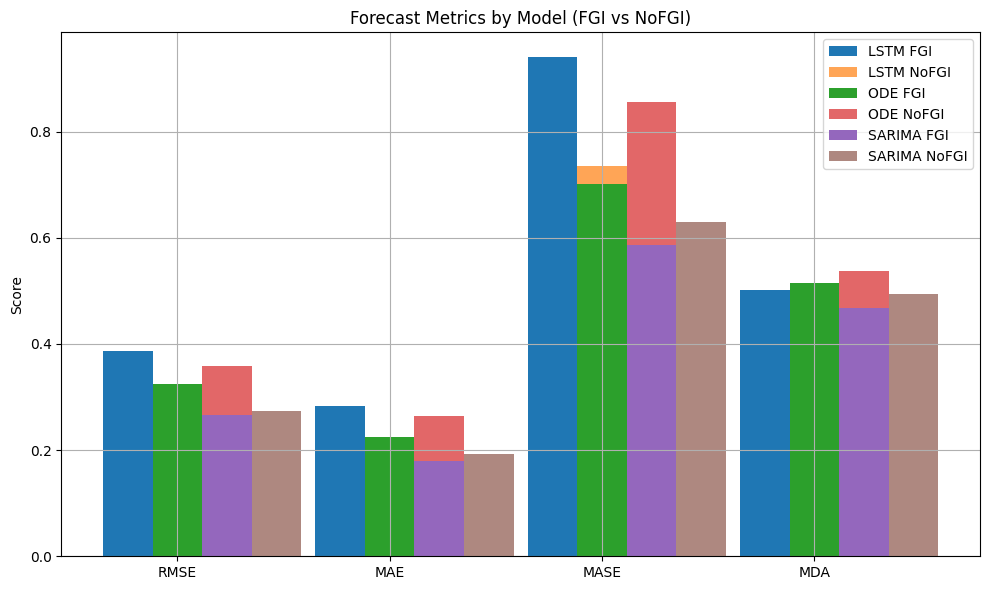

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example metric data (replace with your actual values)
models = ['LSTM', 'ODE', 'SARIMA']
metrics = ['RMSE', 'MAE', 'MASE', 'MDA']

# Fill these with your real data
fgi_scores = [
    [lstm_rmse_fgi, lstm_mae_fgi, lstm_mase_fgi, lstm_mda_fgi],  # LSTM
    [ode_rmse_fgi, ode_mae_fgi, ode_mase_fgi, ode_mda_fgi],  # ODE
    [sarima_rmse_fgi, sarima_mae_fgi, sarima_mase_fgi, sarima_mda_fgi],  # SARIMA
]

nofgi_scores = [
    [lstm_rmse_nofgi, lstm_mae_nofgi, lstm_mase_nofgi, lstm_mda_nofgi],  # LSTM
    [ode_rmse_nofgi, ode_mae_nofgi, ode_mase_nofgi, ode_mda_nofgi],  # ODE
    [sarima_rmse_nofgi, sarima_mae_nofgi, sarima_mase_nofgi, sarima_mda_nofgi],  # SARIMA
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.bar(x + (i - 1) * width / 1.5, fgi_scores[i], width / 1.5, label=f'{model} FGI')
    ax.bar(x + (i - 1) * width / 1.5 + width / 1.5, nofgi_scores[i], width / 1.5, label=f'{model} NoFGI', alpha=0.7)

ax.set_ylabel('Score')
ax.set_title('Forecast Metrics by Model (FGI vs NoFGI)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


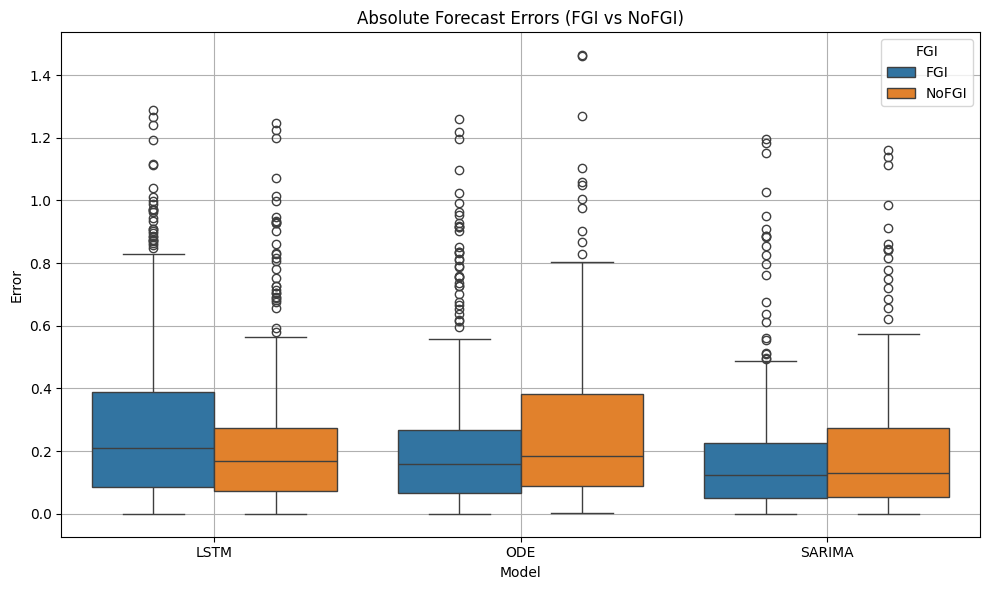

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # make sure this is imported if using np.concatenate

# Combine all error values
all_errors = np.concatenate([
    lstm_abs_errors_fgi_norm, lstm_abs_errors_nofgi_norm,
    ode_abs_errors_fgi_norm, ode_abs_errors_nofgi_norm,
    sarimax_abs_errors_fgi_norm, sarimax_abs_errors_nofgi_norm,
])

# Generate corresponding model labels
model_labels = (
    ['LSTM'] * 390 + ['LSTM'] * 390 +
    ['ODE'] * 390 + ['ODE'] * 390 +
    ['SARIMA'] * 390 + ['SARIMA'] * 390
)

# Generate corresponding FGI condition labels
fgi_labels = (
    ['FGI'] * 390 + ['NoFGI'] * 390 +
    ['FGI'] * 390 + ['NoFGI'] * 390 +
    ['FGI'] * 390 + ['NoFGI'] * 390
)

# Create dataframe
errors = {
    'Model': model_labels,
    'FGI': fgi_labels,
    'Error': all_errors
}
df_errors = pd.DataFrame(errors)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Error', hue='FGI', data=df_errors)
plt.title('Absolute Forecast Errors (FGI vs NoFGI)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparing Neural ODE Performance

In [ ]:
print("TESTING NEURAL ODE PERFORMANCE WITH FGI")

t_stat, p_val = ttest_rel(ode_abs_errors_fgi, sarimax_abs_errors_fgi)
print("Against SARIMAX")
print(f"Paired t-test Statistic: {t_stat:.4f}")
print(f"p-value                : {p_val:.4e}")

t_stat, p_val = ttest_rel(ode_abs_errors_fgi, lstm_abs_errors_fgi)
print("Against LSTM")
print(f"Paired t-test Statistic: {t_stat:.4f}")
print(f"p-value                : {p_val:.4e}")

print("TESTING NEURAL ODE PERFORMANCE WITHOUT FGI")

t_stat, p_val = ttest_rel(ode_abs_errors_nofgi, sarimax_abs_errors_nofgi)
print("Against SARIMAX")
print(f"Paired t-test Statistic: {t_stat:.4f}")
print(f"p-value                : {p_val:.4e}")

t_stat, p_val = ttest_rel(ode_abs_errors_nofgi, lstm_abs_errors_nofgi)
print("Against LSTM")
print(f"Paired t-test Statistic: {t_stat:.4f}")
print(f"p-value                : {p_val:.4e}")

TESTING NEURAL ODE PERFORMANCE WITH FGI
Against SARIMAX
Paired t-test Statistic: 7.6478
p-value                : 1.6196e-13
Against LSTM
Paired t-test Statistic: -4.1423
p-value                : 4.2209e-05
TESTING NEURAL ODE PERFORMANCE WITHOUT FGI
Against SARIMAX
Paired t-test Statistic: 6.0274
p-value                : 3.8708e-09
Against LSTM
Paired t-test Statistic: 3.1209
p-value                : 1.9378e-03


In [ ]:
print("TESTING NEURAL ODE PERFORMANCE WITH FGI (Diebold-Mariano Test)")

dm_stat, p_val = diebold_mariano_test(ode_errors_fgi, sarimax_errors_fgi, h=30, power=2)

print("Against SARIMAX")
print(f"DM Statistic: {dm_stat:.4f}")
print(f"p-value     : {p_val:.2e}")

dm_stat, p_val = diebold_mariano_test(ode_errors_fgi, lstm_errors_fgi, h=30, power=2)

print("Against LSTM")
print(f"DM Statistic: {dm_stat:.4f}")
print(f"p-value     : {p_val:.2e}")

print("TESTING NEURAL ODE PERFORMANCE WITHOUT FGI (Diebold-Mariano Test)")

dm_stat, p_val = diebold_mariano_test(ode_errors_nofgi, sarimax_errors_nofgi, h=30, power=2)

print("Against SARIMAX")
print(f"DM Statistic: {dm_stat:.4f}")
print(f"p-value     : {p_val:.2e}")

dm_stat, p_val = diebold_mariano_test(ode_errors_nofgi, lstm_errors_nofgi, h=30, power=2)

print("Against LSTM")
print(f"DM Statistic: {dm_stat:.4f}")
print(f"p-value     : {p_val:.2e}")

TESTING NEURAL ODE PERFORMANCE WITH FGI (Diebold-Mariano Test)
Against SARIMAX
DM Statistic: 1.8054
p-value     : 7.18e-02
Against LSTM
DM Statistic: -0.9062
p-value     : 3.65e-01
TESTING NEURAL ODE PERFORMANCE WITHOUT FGI (Diebold-Mariano Test)
Against SARIMAX
DM Statistic: 1.6591
p-value     : 9.79e-02
Against LSTM
DM Statistic: 0.8285
p-value     : 4.08e-01


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def rolling_rmse(y_true, y_pred, window_size=30):
    rmse_list = []
    for i in range(0, len(y_true), window_size):
        y_true_win = y_true[i:i+window_size]
        y_pred_win = y_pred[i:i+window_size]

        # Skip incomplete window at the end
        if len(y_true_win) < window_size:
            continue

        # Calculate MSE and then take the square root for RMSE
        mse = mean_squared_error(y_true_win, y_pred_win)
        rmse = np.sqrt(mse)
        rmse_list.append(rmse)
    return rmse_list

In [ ]:
lstm_fgi_rmse = rolling_rmse(true_values, dataframes['lstm_preds_norm_fgi'].values.flatten())
lstm_nofgi_rmse = rolling_rmse(true_values, dataframes['lstm_preds_norm_30_nofgi'].values.flatten())
ode_fgi_rmse = rolling_rmse(true_values, dataframes['ode_preds_norm_fgi'].values.flatten())
ode_nofgi_rmse = rolling_rmse(true_values, dataframes['ode_preds_norm_30_nofgi'].values.flatten())
sarima_fgi_rmse = rolling_rmse(true_values, dataframes['sarimax_preds_norm_fgi'].values.flatten())
sarima_nofgi_rmse = rolling_rmse(true_values, dataframes['sarima_preds_norm_30_nofgi'].values.flatten())

# for normalized
lstm_fgi_rmse_norm = rolling_rmse(true_values_norm, lstm_fgi_preds_norm)
lstm_nofgi_rmse_norm = rolling_rmse(true_values_norm, lstm_nofgi_preds_norm)
ode_fgi_rmse_norm = rolling_rmse(true_values_norm, ode_fgi_preds_norm)
ode_nofgi_rmse_norm = rolling_rmse(true_values_norm, ode_nofgi_preds_norm)
sarima_fgi_rmse_norm = rolling_rmse(true_values_norm, sarimax_fgi_preds_norm)
sarima_nofgi_rmse_norm = rolling_rmse(true_values_norm, sarimax_nofgi_preds_norm)

In [ ]:
from scipy.stats import f_oneway

f_stat, p_val = f_oneway(
    lstm_fgi_rmse_norm,
    lstm_nofgi_rmse_norm,
    ode_fgi_rmse_norm,
    ode_nofgi_rmse_norm,
    sarima_fgi_rmse_norm,
    sarima_nofgi_rmse_norm
)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")


F-statistic: 0.6929
p-value: 0.6305


In [ ]:
from scipy.stats import f_oneway

f_stat, p_val = f_oneway(
    lstm_fgi_rmse_norm,
    ode_fgi_rmse_norm,
    sarima_fgi_rmse_norm,
)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")


F-statistic: 0.8235
p-value: 0.4470


In [ ]:
from scipy.stats import f_oneway

f_stat, p_val = f_oneway(
    lstm_nofgi_rmse_norm,
    ode_nofgi_rmse_norm,
    sarima_nofgi_rmse_norm
)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")


F-statistic: 0.9220
p-value: 0.4069


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import f_oneway

def rolling_mae(y_true, y_pred, window_size=30):
    mae_list = []
    for i in range(0, len(y_true), window_size):
        y_true_win = y_true[i:i+window_size]
        y_pred_win = y_pred[i:i+window_size]

        # Skip incomplete window at the end
        if len(y_true_win) < window_size:
            continue

        mae = mean_absolute_error(y_true_win, y_pred_win)
        mae_list.append(mae)
    return mae_list

# Compute rolling MAE
lstm_fgi_mae_norm = rolling_mae(true_values_norm, lstm_fgi_preds_norm)
lstm_nofgi_mae_norm = rolling_mae(true_values_norm, lstm_nofgi_preds_norm)
ode_fgi_mae_norm = rolling_mae(true_values_norm, ode_fgi_preds_norm)
ode_nofgi_mae_norm = rolling_mae(true_values_norm, ode_nofgi_preds_norm)
sarima_fgi_mae_norm = rolling_mae(true_values_norm, sarimax_fgi_preds_norm)
sarima_nofgi_mae_norm = rolling_mae(true_values_norm, sarimax_nofgi_preds_norm)

# One-way ANOVA using MAE
f_stat, p_val = f_oneway(
    lstm_fgi_mae_norm,
    lstm_nofgi_mae_norm,
    ode_fgi_mae_norm,
    ode_nofgi_mae_norm,
    sarima_fgi_mae_norm,
    sarima_nofgi_mae_norm
)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")


F-statistic: 0.8048
p-value: 0.5500


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def rolling_mase(y_true_full, y_pred, start_idx, window_size=30, seasonality=30):
    """
    y_true_full: full true series (train + val + test)
    y_pred: predicted values for test period only
    start_idx: start index of test period in y_true_full
    window_size: size of rolling window
    seasonality: seasonal lag for naive forecast (e.g., 30 days)
    """
    mase_list = []

    # Loop over rolling windows in test set predictions
    for i in range(0, len(y_pred), window_size):
        y_true_win = y_true_full[start_idx + i : start_idx + i + window_size]
        y_pred_win = y_pred[i : i + window_size]

        if len(y_true_win) < window_size or len(y_pred_win) < window_size:
            continue

        # Compute MAE of predictions
        mae_pred = mean_absolute_error(y_true_win, y_pred_win)

        # Compute naive seasonal MAE on corresponding window
        naive_forecast = y_true_full[start_idx + i - seasonality : start_idx + i + window_size - seasonality]
        # naive_forecast predicts that value at t equals value at t-seasonality
        mae_naive = mean_absolute_error(y_true_win, naive_forecast)

        # Avoid division by zero
        if mae_naive == 0:
            continue

        mase = mae_pred / mae_naive
        mase_list.append(mase)

    return mase_list

# Example usage:
# y_true_full = scaled_df['Target'].values  # full normalized target series
# Assuming test set start index is:
test_start_idx = int(len(scaled_df) * 0.85)  # for 70/15/15 split
y_true_full = scaled_df['Close'].values
lstm_fgi_mase_list = rolling_mase(y_true_full, lstm_fgi_preds_norm, test_start_idx)
lstm_nofgi_mase_list = rolling_mase(y_true_full, lstm_nofgi_preds_norm, test_start_idx)
ode_fgi_mase_list = rolling_mase(y_true_full, ode_fgi_preds_norm, test_start_idx)
ode_nofgi_mase_list = rolling_mase(y_true_full, ode_nofgi_preds_norm, test_start_idx)
sarima_fgi_mase_list = rolling_mase(y_true_full, sarimax_fgi_preds_norm, test_start_idx)
sarima_nofgi_mase_list = rolling_mase(y_true_full, sarimax_nofgi_preds_norm, test_start_idx)
# repeat for other models/predictions

f_stat, p_val = f_oneway(
    lstm_fgi_mase_list,
    lstm_nofgi_mase_list,
    ode_fgi_mase_list,
    ode_nofgi_mase_list,
    sarima_fgi_mase_list,
    sarima_nofgi_mase_list
)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")


F-statistic: 0.9631
p-value: 0.4462


In [ ]:
from scipy.stats import shapiro, levene

# Example: Check normality of one group
print("Shapiro-Wilk Test (normality):", shapiro(ode_fgi_mae_norm))

# Check homogeneity of variances
print("Levene’s Test (equal variances):", levene(
    lstm_fgi_mae_norm,
    lstm_nofgi_mae_norm,
    ode_fgi_mae_norm,
    ode_nofgi_mae_norm,
    sarima_fgi_mae_norm,
    sarima_nofgi_mae_norm
))


Shapiro-Wilk Test (normality): ShapiroResult(statistic=np.float64(0.7388270704982767), pvalue=np.float64(0.0013967861003960887))
Levene’s Test (equal variances): LeveneResult(statistic=np.float64(0.6594534912265769), pvalue=np.float64(0.6553149502473615))


In [ ]:
from scipy.stats import kruskal

h_stat, p_val = kruskal(
    lstm_fgi_mae_norm,
    lstm_nofgi_mae_norm,
    ode_fgi_mae_norm,
    ode_nofgi_mae_norm,
    sarima_fgi_mae_norm,
    sarima_nofgi_mae_norm
)

print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
print(f"p-value: {p_val:.4f}")


Kruskal-Wallis H-statistic: 5.6022
p-value: 0.3469


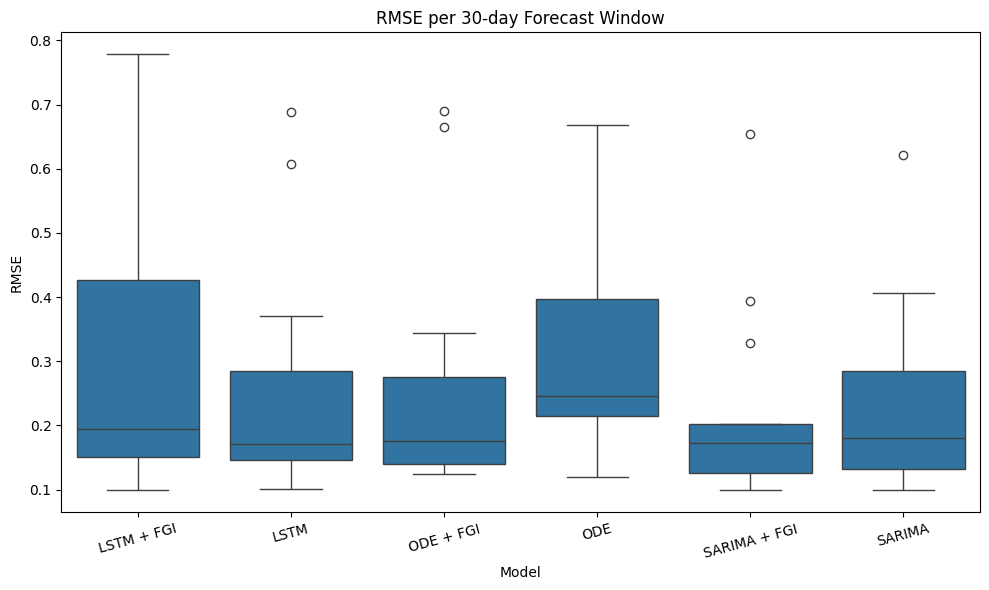

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

# Flatten into DataFrame for seaborn
rmse_df = pd.DataFrame({
    'LSTM + FGI': lstm_fgi_rmse_norm,
    'LSTM': lstm_nofgi_rmse_norm,
    'ODE + FGI': ode_fgi_rmse_norm,
    'ODE': ode_nofgi_rmse_norm,
    'SARIMA + FGI': sarima_fgi_rmse_norm,
    'SARIMA': sarima_nofgi_rmse_norm,
})

# Melt for boxplot
rmse_melted = rmse_df.melt(var_name='Model', value_name='RMSE')

plt.figure(figsize=(10, 6))
sns.boxplot(data=rmse_melted, x='Model', y='RMSE')
plt.title('RMSE per 30-day Forecast Window')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


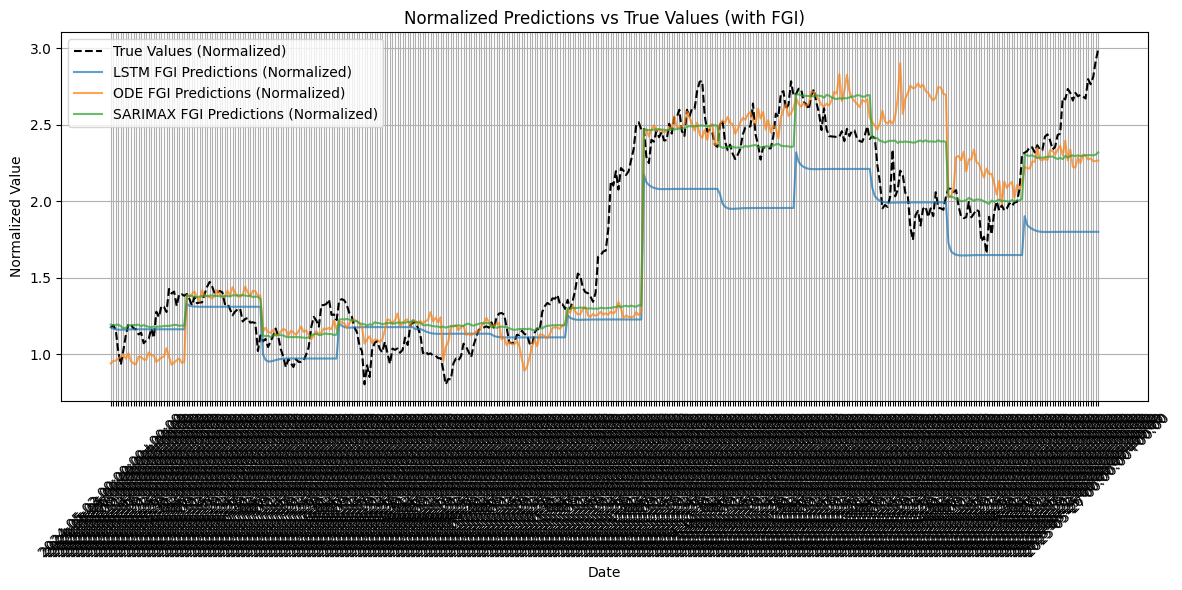

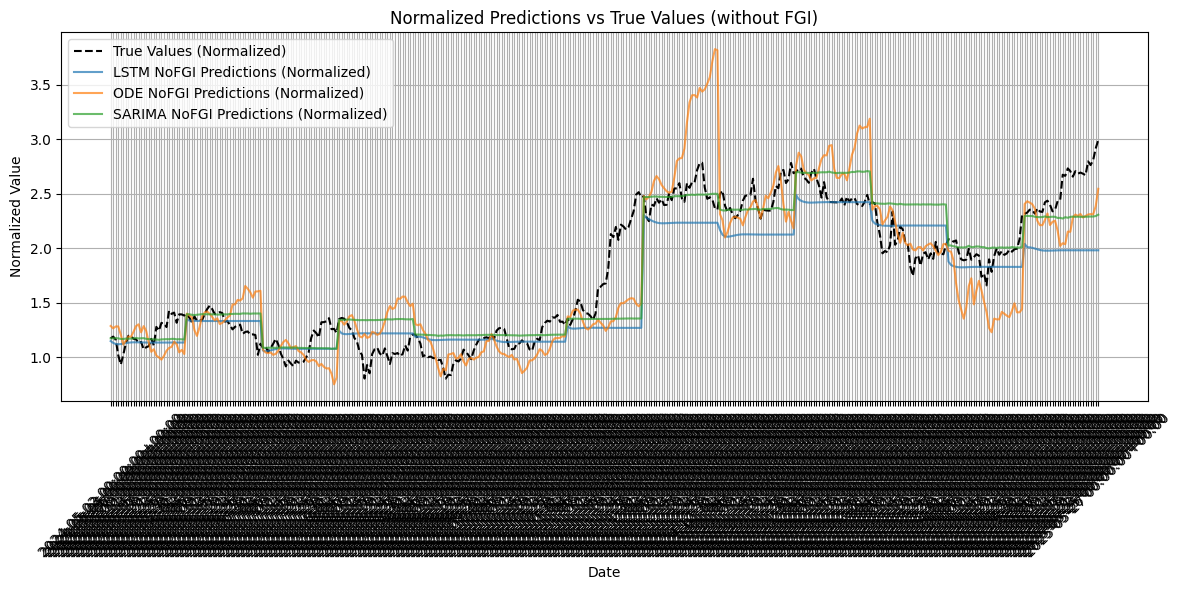

In [ ]:
# Get dates for plotting
dates = dataframes['lstm_rolling_dates']['0'].values

# Plotting for FGI (Normalized)
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values_norm, label='True Values (Normalized)', color='black', linestyle='--')
plt.plot(dates, lstm_fgi_preds_norm, label='LSTM FGI Predictions (Normalized)', alpha=0.7)
plt.plot(dates, ode_fgi_preds_norm, label='ODE FGI Predictions (Normalized)', alpha=0.7)
plt.plot(dates, sarimax_fgi_preds_norm, label='SARIMAX FGI Predictions (Normalized)', alpha=0.7)
plt.title('Normalized Predictions vs True Values (with FGI)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting for NoFGI (Normalized)
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values_norm, label='True Values (Normalized)', color='black', linestyle='--')
plt.plot(dates, lstm_nofgi_preds_norm, label='LSTM NoFGI Predictions (Normalized)', alpha=0.7)
plt.plot(dates, ode_nofgi_preds_norm, label='ODE NoFGI Predictions (Normalized)', alpha=0.7)
plt.plot(dates, sarimax_nofgi_preds_norm, label='SARIMA NoFGI Predictions (Normalized)', alpha=0.7)
plt.title('Normalized Predictions vs True Values (without FGI)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()